<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introdução-e-Cenário" data-toc-modified-id="Introdução-e-Cenário-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introdução e Cenário</a></span><ul class="toc-item"><li><span><a href="#Objetos-e-Elementos-do-Projeto" data-toc-modified-id="Objetos-e-Elementos-do-Projeto-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Objetos e Elementos do Projeto</a></span></li></ul></li><li><span><a href="#Operações-com-Buckets-no-S3" data-toc-modified-id="Operações-com-Buckets-no-S3-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Operações com Buckets no S3</a></span><ul class="toc-item"><li><span><a href="#Via-Console" data-toc-modified-id="Via-Console-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Via Console</a></span></li><li><span><a href="#Via-boto3" data-toc-modified-id="Via-boto3-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Via boto3</a></span></li></ul></li><li><span><a href="#NBAFlow-+-boto3" data-toc-modified-id="NBAFlow-+-boto3-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>NBAFlow + boto3</a></span></li></ul></div>

# Introdução e Cenário

Este notebook tem por objetivo documentar e detalhar os passos realizados para a utilização do serviço **S3** (do inglês, _Simple Storage Service_) da AWS para o armazenamento de objetos gerados pelas funcionalidades do projeto [nbaflow](https://github.com/ThiagoPanini/nbaflow). Dentro da proposta de migração do projeto para uma arquitetura em nuvem, no notebook [NBAFlow-aws-migration](https://github.com/ThiagoPanini/nbaflow/blob/main/notebooks/NBAFlow-aws-migration.ipynb) foi proposta uma documentação completa sobre todas as etapas realizadas dentro do processo de utilização de um serviço de banco de dados relacional (RDS) conectado a um serviço computacional (EC2) para consultar dados de jogadores da NBA e, eventualmente, entregá-los por e-mail ao usuário.

Como resultado dessa frente de migração, foi possível alcançar a seguinte arquitetura já testada e validada dentro dos propósitos iniciais estabelecidos:

<div align="center">
    <br><img src="https://i.imgur.com/8uRYLEH.png" alt="aws_diagram">
</div>

Na prática, a instância EC2 possui scripts python clonados do repositório oficial do projeto no GitHub via SSH e, a partir deles, o desenvolvedor pode manualmente solicitar a execução para dois propósitos específicos:

* _**insert_gamelog_data.py**_: lê um arquivo csv processado previamente e disponibilizado no diretório `data/` para realizar um processo de criação de tabela e ingestão de dados em um banco de dados RDS PostgreSQL.
* _**player_gamelog_from_db.py**_: recebe parâmetros do usuário no prompt de comando (nome de um jogador e temporada válida da NBA) para construir uma query de consulta a ser executada no banco de dados. Os dados são retornados em um formato DataFrame e, opcionalmente, enviados por e-mail para um destinatário fornecido também manualmente.

<div class="alert alert-block alert-info">
<b>Observação:</b> Até este ponto, ainda não foi possível construir uma lógica inteiramente voltada à APIs. Em outras palavras, todas as iterações usuário-código são feitas diretamente pelo prompt de comando e, futuramente, a ideia é que essa comunicação seja feita a partir de uma rota específica onde o usuário possa acessar e enviar suas solicitações de acordo com os filtros desejados. Além disso, ainda existem oportunidades de otimizar esse fluxo a partir da utilização de outros serviços da AWS capazes de servir como um alicerce computacional como, por exemplo, funções lambda.
</div>

___
**_Para entender todo o contexto do projeto, é sugerido o consumo dos seguintes materiais:_**

* [1. NBAFlow - documentação e exploração inicial da API nba_api](https://github.com/ThiagoPanini/nbaflow/blob/main/notebooks/NBAflow-doc-api.ipynb)

* [2. NBAFlow - documentação de fluxo de extração de imagens de jogadores](https://github.com/ThiagoPanini/nbaflow/blob/main/notebooks/NBAflow-players-images.ipynb)

* [3. NBAFlow - estruturação de armazenamento em banco de dados Postgres (OPCIONAL)](https://github.com/ThiagoPanini/nbaflow/blob/main/notebooks/NBAflow-psql.ipynb)

* [4. NBAFlow - primeiros passos da migração para a AWS](https://github.com/ThiagoPanini/nbaflow/blob/main/notebooks/NBAFlow-aws-migration.ipynb)

* [5. Classes estruturadas de processamento de dados](https://github.com/ThiagoPanini/nbaflow/tree/main/core)

* [6. Scripts de processamento de dados utilizando as classes estruturadas](https://github.com/ThiagoPanini/nbaflow/tree/main/scripts)
___

## Objetos e Elementos do Projeto

Assim, em paralelo aos desafios acima explicados e, dentro dos objetivos estabelecidos no início deste material, a grande exploração a ser realizada nas próxima seções gira em torno da utilização do serviço S3 para o armazenamento de alguns objetos presentes em momentos específicos do fluxo de trabalho do projeto NBAFlow. 

Neste cenário, os objetos citados referem-se a:

* **_Arquivos de dados_**: ao longo do desenvolvimento do projeto, foram criados scripts de requisição e processamento de dados de jogadores da NBA para serem analisados posteriormente. Neste propósito, o módulo [`gamelog`](https://github.com/ThiagoPanini/nbaflow/blob/main/core/gamelog.py) foi concebido como uma forma de centralizar o consumo do pacote [nba_api](https://github.com/swar/nba_api) no univero de análise de partidas e estatísticas individuais de jogadores da liga em todas as temporadas disponíveis. Ao longo do processamento, notou-se uma carga excessiva de requisições realizadas, gerando assim um alto tempo de execução para o retorno dos dados de todas as partidas, de todos os jogadores, em todas as temporadas válidas. Assim, visando otimizar as etapas posteriores, todo o histórico processado foi armazenado no arquivo [all_players_gamelog.csv](https://github.com/ThiagoPanini/nbaflow/blob/main/data/all_players_gamelog.csv) contendo todos os insumos necessários para uma análise completa da liga. Exemplificando a utilidade deste arquivo, o script [`insert_gamelog_data`](https://github.com/ThiagoPanini/nbaflow/blob/main/scripts/db_integration/insert_gamelog_data.py) se utiliza deste arquivo csv para inserir registros em uma tabela em um banco de dados PostgreSQL (local ou na nuvem). Como um passo adicional, neste material será proposto o armazenamento deste arquivo em um bucket do S3 para consumo direto via script. Eventualmente, será possível adicionar lógicas no módulo `gamelog` para salvar os resultados das requisições à nba_api direto em buckets do S3 utilizando o SDK [`boto3`](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html).


* **_Imagens de jogadores_**: em uma outra frente extremamente relevante dentro do projeto NBAFlow, foi construída uma lógica capaz de extrair imagens de alta qualidade dos jogadores da NBA diretamente do [site oficial](https://www.nba.com/stats/). Neste cenário, o módulo [`images`](https://github.com/ThiagoPanini/nbaflow/blob/main/core/images.py) foi concebido como uma forma de centralizar os elementos necessários para a consolidação dessas requisições e o salvamento local dos arquivos png recebidos no sistema operacional. Como alternativas, será proposta a inclusão dessas imagens em um bucket do S3 para um armazenamento mais sustentável dentro das propostas gerais do projeto. Eventualmente, será possível aplicar algumas alterações no módulo `images` para que as imagens obtidas pelas requisições já sejam automaticamente salvas em buckets do S3. Para tal, mais uma vez, será preciso utilizar as funcionalidade so SDK `boto3`.

# Operações com Buckets no S3

Iniciando as etapas práticas de construção dos elementos propostos, em um primeiro momento, serão detalhados os passos para a criação de um (ou mais de um) bucket S3 pela AWS utilizando o console de gerenciamento. Posteriormente, um primeiro contato com o SDK `boto3` será fornecido como uma forma eficiente de automatizar, organizar e gerenciar recursos da AWS utilizando a linguagem Python.

## Via Console

Conforme mencionado acima, as primeiras iterações com o serviço S3 serão obtidas a partir do console de gerenciamento da AWS. Nesse formato, a [página do serviço](https://console.aws.amazon.com/s3/home?region=sa-east-1) foi utilizada para a criação de um novo bucket denominado `nbaflow-console`. Nele, dois novos [diretórios](https://docs.aws.amazon.com/AmazonS3/latest/userguide/using-folders.html) foram criados para armazenar _dados_ (arquivos em geral) e _imagens_.

> 📌**Nota**: de acordo com a documentação oficial, no S3, buckets e objetos são os recursos principais, sendo os objetos armazenados em buckets. Mesmo sem o mesmo significado dos sistemas operacionais, é possível criar "diretórios" nos buckets para fins organizacionais, facilitando assim as referências e o armazenamento de objetos. O conceito fundamental de diretórios no S3 é o de simplesmente agrupar objetos a partir de um prefixo adicionado à rota do objeto.

A imagem abaixo traz o bucket `nbaflow-console` criado com os diretórios `data/` e `imgs/` associados:

<div align="center">
    <br><img src="https://i.imgur.com/geU2QZE.png" alt="s3_bucket_nbaflow-console">
</div>

Na sequência, também utilizando as funcionalidades do console, foram realizados os uploads do arquivo `all_players_gamelog.csv` e das imagens png originalmente armazenadas no diretório `data/images/players` do repositório do projeto. A imagem abaixo traz um exemplo do diretório `imgs/` do bucket recém criado já com as imagens de jogadores armazenadas.

<div align="center">
    <br><img src="https://i.imgur.com/0s9jFyP.png" alt="s3_imgs">
</div>

Dessa forma, em um processo altamente intuitivo, foi possível finalizar essa primeira etapa de criação de bucket a partir do console de gerenciamento da AWS. Além disso, o upload dos arquivos selecionados foram realizados dentro dos diretórios criados no bucket. A criação do bucket e o upload dos arquivos foram realizados seguindos todas as configurações padrão propostas no processo o que, em resumo, podem ser descritadas como:

* Bucket criado sem acesso público
* Bucket criado sem versionamento
* Bucket sem encriptação dos dados
* Acesso de leitura e escrita aos objetos está restrito ao owner do bucket

Na próxima seção, os processos de criação, configuração e upload de objetos no bucket serão realizados a partir do SDK Python `boto3`.

## Via boto3

De acordo com a [página oficial de documentação](https://boto3.amazonaws.com/v1/documentation/api/latest/index.html), o SDK `boto3` pode ser resumido a:

> _You use the AWS SDK for Python (Boto3) to create, configure, and manage AWS services, such as Amazon Elastic Compute Cloud (Amazon EC2) and Amazon Simple Storage Service (Amazon S3). The SDK provides an object-oriented API as well as low-level access to AWS services._

Considerando a riqueza de detalhes e de exemplos fornecidos pela própria AWS, grande parte dos primeiros passos aqui documentados serão reproduções adaptadas da página oficial de documentação. Para tal, visando alinhar os propósitos deste notebook, é sugerido que o usuário consumidor do material aqui presente siga algumas instruções básicas de configuração propostas pela documentação do boto3 para que os códigos aqui escritos tenham a eficácia planejada.

Assim, depois de um breve estudo no material oficial, a instalação do boto3 foi feita, dentro do ambiente virtual criado para o projeto NBAFLow, através do comando:

    pip install boto3
    
Mesmo após a instalação, as primeiras tentativas de uso do SDK não foram bem sucedidas. Isto porque, de maneira direta, o boto3 necessita encontrar (ou ser devidamente configurado para isso) credenciais válidas do usuário para que as operações possam ser realizadas. Dessa forma, com a instalação do [AWS CLI](https://aws.amazon.com/pt/cli/) e a execução do comando `aws configure`, foi possível providenciar os insumos necessários para que o boto3 consiga autenticar o usuário dentro da utilização dos recursos na nuvem. Para detalhes adicionais, pode-se analisar a seção de [Configuração](https://boto3.amazonaws.com/v1/documentation/api/latest/guide/quickstart.html#configuration) da documentação oficial.

Por fim, as linhas de código abaixo trazem a importação da biblioteca boto3 juntamente com a criação de um recurso "s3" utilizado para gerenciar e automatizar ações dentro deste serviço de armazenamento. Como validação, serão mostrados todos os buckets presentes na conta AWS configurada.

In [1]:
# Importando biblioteca
import boto3

# Criando recurso e listando buckets
s3 = boto3.resource('s3')
for bucket in s3.buckets.all():
    print(bucket.name)

nbaflow-boto3
nbaflow-console
nbaflow-files


De fato, com o código acima, foi possível verificar que existe apenas um bucket criado na conta configurada da AWS (o recém criado *nbaflow-console*). Ainda nessas primeiras interações com boto3 e buckets S3, o código abaixo é responsável por conectar a um bucket e ler um objeto diretamente na memória. Neste caso, será proposta a leitura de uma das imagens de jogadores da NBA utilizando uma `key` específica que contempla, como prefixo, o diretório criado manualmente no bucket para organização do armazenamento.

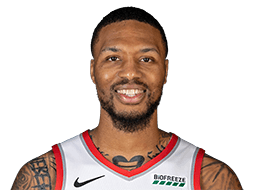

In [2]:
from PIL import Image
from io import BytesIO

# Vinculando bucket alvo
bucket = s3.Bucket('nbaflow-console')

# Coletando objeto
obj = bucket.Object(key='imgs/Damian Lillard.png')
response = obj.get()
file_stream = response['Body']
Image.open(file_stream)

**_Referência:_** https://stackoverflow.com/questions/44043036/how-to-read-image-file-from-s3-bucket-directly-into-memory

Até este ponto, já é possível mensurar o poder fornecido pelo SDK boto3 dentro das possibilidades de gerenciamento de recursos na AWS. Com ele, foi possível ler diretamente na memória um objeto armazenado manualmente em um bucket s3 criado diretamente pelo console. Considerando esta atuação, o bloco de código abaixo irá propor a criação de um **novo bucket** S3 em uma região específica para que, futuramente, este código possa ser encapsulado juntamente com outras funcionalidades de leitura e escrita de objetos dentro de buckets, tudo via boto3.

In [3]:
# Definindo parâmetros
REGION = 'sa-east-1'
BUCKET_NAME = 'nbaflow-boto3'
LOCATION = {'LocationConstraint': REGION}

# Instanciando client
s3_client = boto3.client('s3', region_name=REGION)

# Deletando bucket
try:
    s3_client.delete_bucket(Bucket=BUCKET_NAME)
except Exception as e:
    print(f'Erro ao tentar deletar bucket {BUCKET_NAME}. Exception: {e}')

# Criando um novo bucket
try:
    s3_client.create_bucket(Bucket=BUCKET_NAME,
                            CreateBucketConfiguration=LOCATION)
except Exception as e:
    print(f'Erro ao criar bucket. Exception: {e}')
    
# Listando buckets criados
print()
for bucket in s3.buckets.all():
    print(bucket.name)

Erro ao tentar deletar bucket nbaflow-boto3. Exception: An error occurred (BucketNotEmpty) when calling the DeleteBucket operation: The bucket you tried to delete is not empty
Erro ao criar bucket. Exception: An error occurred (BucketAlreadyOwnedByYou) when calling the CreateBucket operation: Your previous request to create the named bucket succeeded and you already own it.

nbaflow-boto3
nbaflow-console
nbaflow-files


* **_Referência:_** https://boto3.amazonaws.com/v1/documentation/api/latest/guide/s3-example-creating-buckets.html

Com o resultado acima, percebe-se agora a presença de dois buckets listados na conta AWS. Ao atualizar a página no console de gerenciamento, uma nova linha na lista de buckets que realmente a criação foi realizada com sucesso. Entretanto, observando os detalhes relacionados a acesso, mesmo que tenhamos restringido a criação do bucket a uma região em específico da maneira referenciada na documentação, os objetos do novo bucket `nbaflow-boto3` criado podem ser acessados publicamente o que, de fato, pode não ser o desejado pra grande parte das aplicações.

<div align="center">
    <br><img src="https://i.imgur.com/jMzMEeZ.png" alt="s3_public_bucket">
</div>

Assim, para manter um bucket restrito através do boto3, é possível definir um dicionário de configurações com algumas chaves específicas e executar o método `put_public_access_block()` do objeto `s3_client`. Adicionalmente, na referência oficial da [documentação do client S3](https://boto3.amazonaws.com/v1/documentation/api/1.9.42/reference/services/s3.html#S3.Client.create_bucket), pode-se procurar pelo método `create_bucket()` e observar alguns detalhes adicionais sobre como o processo de criação pode ser melhor gerenciado.

In [4]:
# Definindo configurações
BLOCK_PUBLIC_CONFIG = {
    'BlockPublicAcls': True,
    'IgnorePublicAcls': True,
    'BlockPublicPolicy': True,
    'RestrictPublicBuckets': True
}

# Modificando acesso do bucket
response_public = s3_client.put_public_access_block(Bucket=BUCKET_NAME,
                                                    PublicAccessBlockConfiguration=BLOCK_PUBLIC_CONFIG)
response_public

{'ResponseMetadata': {'RequestId': 'DB28ZTKFAJG7ETKT',
  'HostId': 'SWi0tLuoOwukWj+L72ZApRXlEG2Wvlsd34ErodgcqQb7AlftkvSdtxW9KTAeEJDNWoBzXJkz25Y=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'SWi0tLuoOwukWj+L72ZApRXlEG2Wvlsd34ErodgcqQb7AlftkvSdtxW9KTAeEJDNWoBzXJkz25Y=',
   'x-amz-request-id': 'DB28ZTKFAJG7ETKT',
   'date': 'Sat, 28 Aug 2021 01:49:52 GMT',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0}}

Após a execução do bloco de código acima, foi possível verificar, no console, o efeito da alteração das permissões no bucket `nbaflow-boto3`.

<div align="center">
    <br><img src="https://i.imgur.com/c4VYbgH.png" alt="s3_notpublic_bucket">
</div>

Assim como a criação e leitura de objetos em buckets, é possível realizar a ingestão de novos objetos a partir da definição de chaves específicas que, eventualmente, podem conter informações a respeito de _diretórios_ de armazenamento. Como informado anteriormente, os diretórios em buckets do S3 funcionam, em essência, como organizadores de objetos e, na prática, seu impacto se reflete como um prefixo das _chaves_ relacionadas aos objetos. Dessa forma, ao definir uma chave de objeto com uma referência semelhante a um caminho de diretório, o mesmo será automaticamente armazenado dentro desta estrutura.

Para ilustrar este conceito, será proposta a leitura, em memória, de um arquivo csv salvo localmente para que, posteriormente, seja aplicado um processo de ingestão dos dados no bucket S3 recém criado.

In [5]:
BUCKET_NAME

'nbaflow-boto3'

In [6]:
# Definindo variáveis
FILEPATH = r'C:\Users\thipa\workspaces\nbaflow\dev\data\all_players_gamelog.csv'
KEY = 'data/all_players_gamelog.csv'
with open(FILEPATH, 'rb') as f:
    file = f.read()
    
# Coletando recurso e realizando upload
s3_client.put_object(Bucket=BUCKET_NAME, Body=file, Key=KEY)

{'ResponseMetadata': {'RequestId': 'DB2B2C164EXC5E7V',
  'HostId': 'JHbmPSyLGfEjpcTHa6ZFbOtgCMC1owIf1ISDkvgq290DUc4HZdqvfgdw3n5lWkAQN6oC1oUAFcg=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': 'JHbmPSyLGfEjpcTHa6ZFbOtgCMC1owIf1ISDkvgq290DUc4HZdqvfgdw3n5lWkAQN6oC1oUAFcg=',
   'x-amz-request-id': 'DB2B2C164EXC5E7V',
   'date': 'Sat, 28 Aug 2021 01:49:52 GMT',
   'etag': '"412281cfcdc50b2bcac43630b4d0099a"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"412281cfcdc50b2bcac43630b4d0099a"'}

In [7]:
# Testando outra forma de uploag
KEY2 = 'data/all_players_gamelog_2.csv'
s3_client.upload_file(Filename=FILEPATH, Bucket=BUCKET_NAME, Key=KEY2)

https://www.stackvidhya.com/write-a-file-to-s3-using-boto3/

https://stackoverflow.com/questions/40336918/how-to-write-a-file-or-data-to-an-s3-object-using-boto3

In [8]:
def upload_object():
    

SyntaxError: unexpected EOF while parsing (Temp/ipykernel_8720/1872490330.py, line 2)

Nos exemplos acima, foram utilizadas dois métodos distintos para o upload de objetos em um bucket S3. No primeiro exemplo, o método `put_object()` recebe um arquivo em formato binário como argumento Body do método, permitindo assim com que arquivos já lidos em memória sejam transferidos pro bucket. No segundo caso, o método `upload_file()` recebe, de forma direta, um caminho do arquivo salvo localmente na máquina para que a ingestão seja realizada sem a leitura explícita.

**_Referências:_**
* https://boto3.amazonaws.com/v1/documentation/api/latest/guide/s3-uploading-files.html
* https://boto3.amazonaws.com/v1/documentation/api/1.9.42/reference/services/s3.html#S3.Client.upload_file
* https://stackoverflow.com/questions/1939743/amazon-s3-boto-how-to-create-a-folder
* https://intellipaat.com/community/41744/using-boto3-how-can-i-create-a-folder-inside-s3

# NBAFlow + boto3

Após uma jornada inicial em algumas operações básicas com S3 utilizando o boto3, nesta seção será proposta a aplicação de alguns recursos já construídos para o projeto NBAFlow para que, de forma adaptada, o SDK boto3 possa ser utilizado como uma forma adicional de prover a escrita e leitura de objetos direto no S3. Para validar, de fato, este tipo de abordagem, será desenvolvido um bloco de código capaz de navegar por todas as imagens de jogadores salvas localmente em formato png e realizar ingestões individuais dos arquivos diretamente em um bucket s3.

In [ ]:
# Importando bibliotecas
import boto3
from botocore.exceptions import ClientError, EndpointConnectionError
import os
import logging

In [ ]:
# Definindo função para gerenciamento de logs
def log_config(logger, level=logging.DEBUG, 
               log_format='%(levelname)s;%(asctime)s;%(filename)s;%(module)s;%(lineno)d;%(message)s',
               log_filepath=os.path.join(os.getcwd(), 'exec_log/execution_log.log'),
               flag_file_handler=False, flag_stream_handler=True, filemode='a'):
    """
    Função que recebe um objeto logging e aplica configurações básicas ao mesmo
    
    Parâmetros
    ----------
    :param logger: objeto logger criado no escopo do módulo [type: logging.getLogger()]
    :param level: level do objeto logger criado [type: level, default=logging.DEBUG]
    :param log_format: formato do log a ser armazenado [type: string]
    :param log_filepath: caminho onde o arquivo .log será armazenado 
        [type: string, default='exec_log/execution_log.log']
    :param flag_file_handler: define se será criado um arquivo de armazenamento de log
        [type: bool, default=False]
    :param flag_stream_handler: define se as mensagens de log serão mostradas na tela
        [type: bool, default=True]
    :param filemode: tipo de escrita no arquivo de log [type: string, default='a' (append)]
    
    Retorno
    -------
    :return logger: objeto logger pré-configurado
    """

    # Setting level for the logger object
    logger.setLevel(level)

    # Creating a formatter
    formatter = logging.Formatter(log_format, datefmt='%Y-%m-%d %H:%M:%S')

    # Creating handlers
    if flag_file_handler:
        log_path = '/'.join(log_filepath.split('/')[:-1])
        if not isdir(log_path):
            makedirs(log_path)

        # Adding file_handler
        file_handler = logging.FileHandler(log_filepath, mode=filemode, encoding='utf-8')
        file_handler.setFormatter(formatter)
        logger.addHandler(file_handler)

    if flag_stream_handler:
        # Adding stream_handler
        stream_handler = logging.StreamHandler()
        stream_handler.setFormatter(formatter)    
        logger.addHandler(stream_handler)

    return logger

# Instanciando e configurando objeto de log
logger = logging.getLogger('notebook')
logger = log_config(logger)

In [ ]:
# Definindo variáveis do ambiente S3
REGION = 'sa-east-1'
BUCKET_NAME = 'nbaflow-files'
IMGS_FOLDER = 'imgs/'
DATA_FOLDER = 'data/'

# Definindo variáveis de configuração do bucket
LOCATION = {'LocationConstraint': REGION}
BLOCK_PUBLIC = True
BLOCK_PUBLIC_CONFIG = {
    'BlockPublicAcls': True,
    'IgnorePublicAcls': True,
    'BlockPublicPolicy': True,
    'RestrictPublicBuckets': True
}

# Definindo variáveis de repositório local
DATA_PATH = r'C:/Users/thipa/workspaces/nbaflow/data'
IMGS_PATH = os.path.join(DATA_PATH, 'images/players')

# Instanciando client e resource do S3
try:
    s3_client = boto3.client('s3', region_name=REGION)
    s3 = boto3.resource('s3', region_name=REGION)
except Exception as e:
    logger.error(f'Erro ao instanciar o client ou o recurso S3. Exception: {e}')

# Gerenciando criação de um novo bucket
try:
    # Listando buckets já existentes
    buckets = [bucket.name for bucket in s3.buckets.all()]
    if BUCKET_NAME not in buckets:
        s3.create_bucket(Bucket=BUCKET_NAME,
                         ACL='private',
                         CreateBucketConfiguration=LOCATION)

        # Definindo acesso público restrito
        if BLOCK_PUBLIC:
            response = s3_client.put_public_access_block(Bucket=BUCKET_NAME,
                                                         PublicAccessBlockConfiguration=BLOCK_PUBLIC_CONFIG)
        logger.info(f'Bucket {BUCKET_NAME} criado com sucesso')
    else: 
        # Bucket já existente
        logger.warning(f'Bucket {BUCKET_NAME} já existente. A criação de um novo bucket não será realizada.')

except EndpointConnectionError as edperror:
    logger.error(f'Erro de conexão ao endpoint. Verificar região fornecida na instância do recurso ou do client. Exception: {edperror}')


In [ ]:
# Definindo função encapsulada para a criação de novos buckets na AWS
def create_bucket(bucket_name, region, acl='private', **kwargs):
    """
    Função criada para consolidar os principais elementos de
    criação de buckets s3 através do SDK boto3. O código aqui
    encapsulado visa propor um detalhamento mais claro sobre
    as etapas mais comuns de criação de bucket, providenciando
    ao usuário uma maior abstração nas configurações mais
    básicas dentro deste universo. De maneira geral, esta
    função instancia um recurso s3 via boto3 e utiliza o método
    create_bucket() para consolidar as operações de criação
    de buckets.
    
    Para detalhes adicionais ou operações mais avançadas
    relacionadas à criação de buckets, verificar a documentação
    oficial do boto3 na AWS.
    
    Parâmetros
    ----------
    :param bucket_name:
        Referência do bucket a ser criado dentro da conta
        AWS configurada para a utilização do boto3. O nome
        do bucket deve seguir as diretrizes propostas pela
        própria AWS dentro das boas práticas e restrições
        estabelecidas.
        [type: string]
        
    :param region:
        Região a qual o bucket será criado. Este argumento
        também é utilizado para a criação do dicionário
        de configuração de localização do bucket a ser 
        passado também como parâmetro do método
        create_bucket() do recurso s3 instanciado.
        
    :param acl:
        Parâmetro que define o controle de acesso definido
        para o bucket (Access Control List). Neste contexto
        o argumento acl propõe a utilização de um bloco
        consolidado de controle predefinido dentro das 
        diretrizes da AWS. Através da documentação de 
        referência do SDK, é possível visualizar as opções 
        possíveis enblocadas para a definição de controle 
        de acesso.
        [type: string, default='private']
        
    Argumentos Adicionais
    ---------------------
    :kwarg block_public:
        Flag que define a modificação da política de acesso
        ao bucket criado. Ao ser configurado como True, é
        instanciado um client s3 via boto3 e executado o
        método put_public_access_block() para bloqueio de
        todo acesso público proveniente ACLs ou configurações
        adicionais do bucket. A definição exata do bloqueio
        de acesso público é definida a partir do argumento
        adicional block_public_config.
        [type: bool, default=True]
    
    :kwarg block_public_config:
        Dicionário de configuração com chaves específicas 
        de definição das restrições a serem aplicadas no
        método put_public_acess_block() do client s3
        instanciado.
        [type: dict, default={
                        'BlockPublicAcls': True,
                        'IgnorePublicAcls': True,
                        'BlockPublicPolicy': True,
                        'RestrictPublicBuckets': True
                    }]
    """
    
    # Instanciando recurso S3 e listando buckets existentes
    s3 = boto3.resource('s3', region_name=region)
    try:
        buckets = [bucket.name for bucket in s3.buckets.all()]
    except EndpointConnectionError as ece:
        logger.error(f'Erro de conexão ao endpoint. Verificar região {region}. Exception: {ece}')
        return None
    
    # Validando existência do bucket
    if bucket_name in buckets:
        logger.warning(f'Bucket {bucket_name} já existente. A criação de um novo bucket não será realizada.')
        return None
    else:
        # Criando um novo bucket
        try:
            location = kwargs['location'] if 'location' in kwargs else {'LocationConstraint': region}
            s3.create_bucket(
                Bucket=bucket_name, 
                ACL=acl,
                CreateBucketConfiguration=location
            )
            logger.info(f'Bucket {bucket_name} criado com sucesso.')
        except ClientError as ce:
            logger.error(f'Erro durante a criação do bucket. Exception: {ce}')
            
    # Validando bloqueio de acesso público ao bucket
    block_public = kwargs['block_public'] if 'block_public' in kwargs else True
    if block_public:
        config = {
            'BlockPublicAcls': True,
            'IgnorePublicAcls': True,
            'BlockPublicPolicy': True,
            'RestrictPublicBuckets': True
        }
        block_public_config = kwargs['block_public_config'] if 'block_public_config' in kwargs else config
        
        # Instanciando sessão e configurando bloqueio de acesso público
        try:
            s3_client = boto3.client('s3', region_name=region)
            response = s3_client.put_public_access_block(Bucket=bucket_name,
                                                         PublicAccessBlockConfiguration=block_public_config)
        except Exception as e:
            logger.warning(f'Erro ao instanciar client e bloquear acesso público ao bucket {bucket_name}. Exception: {e}')
            

In [ ]:
# Definindo variáveis do ambiente S3
REGION = 'sa-east-1'
BUCKET_NAME = 'nbaflow-files'
IMGS_FOLDER = 'imgs/'
DATA_FOLDER = 'data/'

# Definindo variáveis de configuração do bucket
LOCATION = {'LocationConstraint': REGION}
ACL = 'private'
BLOCK_PUBLIC = True
BLOCK_PUBLIC_CONFIG = {
    'BlockPublicAcls': True,
    'IgnorePublicAcls': True,
    'BlockPublicPolicy': True,
    'RestrictPublicBuckets': True
}

# Definindo variáveis de repositório local
DATA_PATH = r'C:/Users/thipa/workspaces/nbaflow/data'
IMGS_PATH = os.path.join(DATA_PATH, 'images/players')

In [ ]:
# Deletando bucket (opcional)
s3_client = boto3.client('s3', region_name=REGION)
s3_client.delete_bucket(Bucket=BUCKET_NAME)

In [ ]:
# Criando novo bucket
create_bucket(bucket_name=BUCKET_NAME, region=REGION, acl=ACL, 
              block_public=BLOCK_PUBLIC, block_public_config=BLOCK_PUBLIC_CONFIG)

In [ ]:
s3 = boto3.resource('s3')
bucket = s3.Bucket('nbaflow-boto3')
bucket.delete()

In [ ]:
bucket.objects.all().delete()

In [ ]:
bucket_objects = [obj for obj in bucket.objects.all()]
bucket_objects[0].e_tag

In [ ]:
from botocore.errorfactory import No

In [ ]:
[e for e in dir(s3.exceptions) if e.endswith('Exception')]

In [ ]:
s3_client.exceptions.BucketNotEmpty

In [ ]:
boto3.client('s3').exceptions.NoSuchBucket

In [ ]:
boto3.client('s3').exceptions.BucketNotEmpty

In [ ]:
DATA_PATH = r'C:/Users/thipa/workspaces/nbaflow/dev/data/'
import os
print(os.listdir(DATA_PATH))

In [ ]:
for path, dirs, files in os.walk(DATA_PATH):
    for d in dirs:
        print(d)
    """for name in files:
        filepath = os.path.join(path, name)
        print(name)
        #print(os.path.basename(filepath))"""

In [ ]:
path, dirs, files = os.walk(DATA_PATH)

In [ ]:
len([name for _, _, files in os.walk(DATA_PATH) for name in files])

In [ ]:
for path, dirs, files in os.walk(DATA_PATH):
    for name in files:
        filepath = os.path.join(path, name)
        key = filepath.replace(DATA_PATH, 'root/')
        print(key)

In [ ]:
os.path.basename(DATA_PATH)

In [ ]:
os.path.sep

In [ ]:
DATA_PATH

In [ ]:
DATA_PATH.replace(os.path.sep, '')

https://towardsdatascience.com/reading-and-writing-files-from-to-amazon-s3-with-pandas-ccaf90bfe86c

In [ ]:
from io import BytesIO, StringIO
import pandas as pd

bucket = 'nbaflow-files'
obj = s3_client.get_object(Bucket=bucket, Key='imgs/Damian Lillard.png')
data_stream = BytesIO(obj['Body'].read())
pd.read_csv(data_stream)

In [ ]:
s3_client.exceptions.NoSuchKey

In [ ]:
import os
local_dir = os.path.join(os.getcwd(), 's3_temp')

paginator = s3_client.get_paginator('list_objects')
for result in paginator.paginate(Bucket='nbaflow-files', Delimiter='/', Prefix=''):
    prefixes = result.get('CommonPrefixes')
    if prefixes is not None:
        for subdir in result.get('CommonPrefixes'):
            print(subdir.get('Prefix'))
            
    contents = result.get('Contents', [])
    for file in contents:
        obj_key = file.get('Key')
        local_path = os.path.join(local_dir, obj_key)
        if not os.path.exists(os.path.dirname(local_path)):
            os.makedirs(os.path.dirname(local_path))
        s3_client.download_file('nbaflow-files', obj_key, local_path)

In [ ]:
import os
local_dir = os.path.join(os.getcwd(), 's3_temp')

def download_all_objects(bucket, prefix='', local=local_dir):
    paginator = s3_client.get_paginator('list_objects')
    for result in paginator.paginate(Bucket='nbaflow-files', Delimiter='/', Prefix=''):
        prefixes = result.get('CommonPrefixes')
        if prefixes is not None:
            for subdir in result.get('CommonPrefixes'):
                #print(subdir.get('Prefix'))
                download_all_objects(bucket=bucket, prefix=subdir.get('Prefix'))

        contents = result.get('Contents', [])
        for file in contents:
            obj_key = file.get('Key')
            local_path = os.path.join(local_dir, obj_key)
            if not os.path.exists(os.path.dirname(local_path)):
                os.makedirs(os.path.dirname(local_path))
            s3_client.download_file('nbaflow-files', obj_key, local_path)

In [ ]:
download_all_objects(bucket='nbaflow-files')

In [ ]:
bucket = s3.Bucket('nbaflow-files')
objects = [obj for obj in bucket.objects.all()]
objects

In [ ]:
os.path.dirname(objects[50].key)

In [ ]:
objects[50].key

In [ ]:
import os
local_dir = os.path.join(os.getcwd(), 's3_temp')

paginator = s3_client.get_paginator('list_objects')
for result in paginator.paginate(Bucket='nbaflow-files', Delimiter='/', Prefix=''):
    prefixes = result.get('CommonPrefixes')
    if prefixes is not None:
        for subdir in result.get('CommonPrefixes'):
            print(subdir.get('Prefix'))
            
    contents = result.get('Contents', [])
    for file in contents:
        obj_key = file.get('Key')
        local_path = os.path.join(local_dir, obj_key)
        if not os.path.exists(os.path.dirname(local_path)):
            os.makedirs(os.path.dirname(local_path))
        s3_client.download_file('nbaflow-files', obj_key, local_path)

In [ ]:
objects = s3.list_objects(Bucket='nbaflow-files')['Contents']

In [42]:
import os
import boto3

s3_resource = boto3.resource('s3')
s3_client = boto3.client('s3')

# Coletando estrutura do bucket com chaves e prefixos
bucket = s3_resource.Bucket('nbaflow-files')
keys = [obj.key for obj in bucket.objects.all()]
prefixes = sorted(list(dict.fromkeys([os.path.dirname(k) for k in keys if '/' in k ])))

# Criando estrutura local de diretórios com os prefixos
local_dir = os.path.join(os.getcwd(), 's3_temp')
for dirname in prefixes:
    try:
        print(os.path.isdir(os.path.join(local_dir, dirname)))
        os.makedirs(os.path.join(local_dir, dirname))
    except FileExistsError as fee:
        continue
        
# Realizando o download dos objetos
for k in keys:
    s3_client.download_file('nbaflow-files', k, os.path.join(local_dir, k))

True
True
True
True
True


https://qastack.com.br/programming/30249069/listing-contents-of-a-bucket-with-boto3

In [40]:
keys = [obj.key for obj in bucket.objects.filter(Prefix='')]
keys

['all_players_gamelog.csv',
 'backup/2019-20_gamelog.csv',
 'backup/2020-21_gamelog.csv',
 'backup/all_players_gamelog.csv',
 'backup/all_players_gamelog_101_150.csv',
 'backup/all_players_gamelog_151_200.csv',
 'backup/all_players_gamelog_1_50.csv',
 'backup/all_players_gamelog_201_250.csv',
 'backup/all_players_gamelog_251_300.csv',
 'backup/all_players_gamelog_301_350.csv',
 'backup/all_players_gamelog_351_400.csv',
 'backup/all_players_gamelog_401_450.csv',
 'backup/all_players_gamelog_451_end.csv',
 'backup/all_players_gamelog_51_100.csv',
 'backup/images/Aaron Gordon.png',
 'backup/images/Aaron Holiday.png',
 'backup/images/Abdel Nader.png',
 'backup/images/Adam Mokoka.png',
 'backup/images/Al Horford.png',
 'backup/images/Al-Farouq Aminu.png',
 'backup/images/Alec Burks.png',
 'backup/images/Alen Smailagic.png',
 'backup/images/Alex Caruso.png',
 'backup/images/Alex Len.png',
 'backup/images/Alfonzo McKinnie.png',
 'backup/images/Alize Johnson.png',
 'backup/images/Amida Brimah.

In [30]:
local_dir = os.path.join(os.getcwd(), 's3_temp')
for dirname in prefixes:
    os.makedirs(os.path.join(local_dir, dirname))

In [28]:
local_dir = os.path.join(os.getcwd(), 's3_temp')
for dirname in prefixes:
    try:
        os.makedirs(os.path.join(local_dir, dirname))
    except FileExistsError as fee:
        continue

In [ ]:
keys = [obj.key for obj in bucket.objects.all()]

In [18]:
os.path.dirname(keys[10])

'backup'

In [19]:
os.path.dirname(keys[50])

'backup/images'

In [16]:
keys[10].split('/')[:-1]

['backup']

In [17]:
keys[50].split('/')[:-1]

['backup', 'images']

In [12]:
def get_list_of_prefixes_from_prefix(bucket, prefix):
    """gets list of prefixes for given bucket and prefix"""
    list_of_prefixes = []
    paginator = boto3.resource('s3').meta.client.get_paginator('list_objects')
    for result in paginator.paginate(Bucket=bucket, Prefix=prefix, Delimiter='/'):
        # print(result)
        if 'CommonPrefixes' in result:
            prefixes = [f['Prefix'] for f in result['CommonPrefixes']]
            list_of_prefixes.extend(prefixes)
    return list_of_prefixes

list_of_prefixes = get_list_of_prefixes_from_prefix('nbaflow-files', '')
list_of_prefixes

['backup/', 'images/']